## Regression with Random Forest Regressor 

We start by importing all the necessary libraries and by loading the data 

In [58]:
#import libraries 
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import ydata_profiling
from ydata_profiling import ProfileReport
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
#load the data 
df = pd.read_csv("../data/processed/grouped_date_mun_hour.csv")
#df['geometry'] = df['geometry'].apply(wkt.loads)
#df = gpd.GeoDataFrame(df).set_crs('EPSG:4326')
#df['hour_blocks'] = df['time'].str.split(':').str[0].astype(int)

In [3]:
df = df.drop(['class', 'Unnamed: 0'], axis=1)

In [4]:
df 

,municipality.name,hour_category,temperature,minTemperature,maxTemperature,precipitation,wind_speed,wind_dir,curr_cell,curr_site,tweet_count,month,day,day_of_week,population,elevation
0,Andalo,A,9.200000,8.5,12.000000,0.0,NaN,NaN,0.000000,0.000000,1,11,1,4,1024,1042
1,Baselga di Pinè,B,11.533333,8.0,13.733333,0.0,0.2,236.0,5.996413,0.016458,3,11,1,4,4928,964
2,Baselga di Pinè,C,11.433333,7.3,12.966667,0.0,0.0,184.0,10.637787,0.017426,3,11,1,4,4928,964
3,Baselga di Pinè,D,9.350000,6.6,12.200000,0.0,NaN,NaN,18.809585,0.024556,2,11,1,4,4928,964
4,Bedollo,B,14.120000,8.7,14.500000,0.0,0.3,232.5,0.383955,0.015358,5,11,1,4,1476,1059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5026,Vigo di Fassa,B,-7.450000,-10.0,0.300000,0.0,NaN,NaN,0.000000,0.000000,4,12,31,1,1219,1382
5027,Vigo di Fassa,C,-3.966667,-10.0,0.300000,0.0,NaN,NaN,0.000000,0.000000,3,12,31,1,1219,1382
5028,Vigo di Fassa,D,-8.125000,-10.0,0.300000,0.0,NaN,NaN,0.000000,0.000000,4,12,31,1,1219,1382
5029,Villa Agnedo,C,0.533333,-3.3,4.900000,0.0,NaN,NaN,9.225448,0.044170,3,12,31,1,994,356


Then we define the features

In [6]:
X = df[['month', 'day', 'day_of_week',
        'municipality.name', 
        'hour_category', 
        'temperature', 
        'minTemperature', 
        'maxTemperature', 
        'precipitation',
        'wind_speed',
        'wind_dir',
        'curr_cell',
        'curr_site',
       'population', 'elevation']]
y = df['tweet_count']

We now preprocess the data: first, we need to separate the features in numerical and categorical

In [9]:

categorical_features = ['day_of_week', 'municipality.name', 'hour_category']  # Any string or categorical features
numerical_features = ['temperature', 
                      'minTemperature', 
                      'maxTemperature', 
                      'precipitation', 
                      'wind_speed',
                      'wind_dir',
                      'curr_cell',
                      'curr_site', 'day', 'month', 'population', 'elevation']

Second, we enconde the categorical data with label encoding

In [11]:
le = LabelEncoder()
for feat in categorical_features:
    X[feat] = le.fit_transform(X[feat])

C:\Users\Nicola\AppData\Local\Temp\ipykernel_14840\4052801819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feat] = le.fit_transform(X[feat])
C:\Users\Nicola\AppData\Local\Temp\ipykernel_14840\4052801819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feat] = le.fit_transform(X[feat])
C:\Users\Nicola\AppData\Local\Temp\ipykernel_14840\4052801819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

We then scale the numerical features, convert them back to dataframe form and finally recombine categorical and numerical data

In [13]:
# Scale the numerical features
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(X[numerical_features])

In [14]:
# Convert the scaled numerical features back to a DataFrame
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_features)

In [15]:
# Combine the scaled numerical features and encoded categorical features
X = pd.concat([scaled_numerical_df, X[categorical_features].astype('category')], axis=1)

The result is 

In [27]:
X.dtypes

temperature           float64
minTemperature        float64
maxTemperature        float64
precipitation         float64
wind_speed            float64
wind_dir              float64
curr_cell             float64
curr_site             float64
day                   float64
month                 float64
population            float64
elevation             float64
day_of_week          category
municipality.name    category
hour_category        category
dtype: object

We now proceed to implement our regressor, first we split the data into train dataset and test dataset 

In [30]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Then we initialise and train the random forest 

In [35]:
# Initialize 
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
#train 
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

we calculate the predictions 

In [65]:
y_pred = rf_regressor.predict(X_test)


In [38]:
X

,temperature,minTemperature,maxTemperature,precipitation,wind_speed,wind_dir,curr_cell,curr_site,day,month,population,elevation,day_of_week,municipality.name,hour_category
0,1.373326,2.087336,1.202285,-0.232605,NaN,NaN,-0.547394,-0.361105,-1.770839,-1.314089,-0.365925,0.942593,4,4,0
1,1.913231,1.965734,1.647047,-0.232605,-0.812710,0.436950,-0.210584,-0.257296,-1.770839,-1.314089,-0.207281,0.731736,4,6,1
2,1.890092,1.795490,1.450325,-0.232605,-0.998197,-0.106207,0.050115,-0.251192,-1.770839,-1.314089,-0.207281,0.731736,4,6,2
3,1.408034,1.625247,1.253603,-0.232605,NaN,NaN,0.509113,-0.206222,-1.770839,-1.314089,-0.207281,0.731736,4,6,3
4,2.511754,2.135977,1.843769,-0.232605,-0.719966,0.400392,-0.525828,-0.264234,-1.770839,-1.314089,-0.347558,0.988549,4,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5026,-2.479282,-2.411956,-1.799863,-0.232605,NaN,NaN,-0.547394,-0.361105,1.500313,0.760984,-0.358001,1.861713,1,152,1
5027,-1.673281,-2.411956,-1.799863,-0.232605,NaN,NaN,-0.547394,-0.361105,1.500313,0.760984,-0.358001,1.861713,1,152,2
5028,-2.635469,-2.411956,-1.799863,-0.232605,NaN,NaN,-0.547394,-0.361105,1.500313,0.760984,-0.358001,1.861713,1,152,3
5029,-0.632036,-0.782483,-0.619531,-0.232605,NaN,NaN,-0.029214,-0.082506,1.500313,0.760984,-0.367145,-0.911868,1,154,2


then we evaluate the model by calculating some meaningful estimators  


In [89]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")
print(f"MSE: {mse}")

# average tweet count Trentino
average_tweet_count_trentino = df['tweet_count'].mean()

print(f"Average tweet count for the whole of Trentino: {average_tweet_count_trentino}")


Mean Absolute Error: 3.427934458788481
R² Score: 0.5666704205265447
MSE: 64.5279971201589
Average tweet count for the whole of Trentino: 5.552772808586762


The mean absolute error illustrates that the typical error we can expect from tweetcount prediction is of 3-4 tweets. 
Unfortunatly given that most municipalities have a tweet count around 5-6 this is really not good. 
The $\R^2$ factor is indeed just fair, we are certain we are missing important factors which influence the number of tweeters.
In the classification notebook we verified that a social, scheduled (and therefore predictable) event such as the "Universiadi" caused a major misprediction. From the regression we can verify that the actual error is (50? ). 
It is clear that in order to be quantitative, in order to reliably predict the social pulse we should be able to complete the dataframe with local events, specific holidays and major news events. Since this is the only available dataframe we conclude that this type of survey is really just fit for classification. 
Just not to be tragic or drastic, we signal that this huge mean absolute error may be driven mainly by the very high peaks , such as the ones that have been recorded on 13 and 14 december; this possibility is higlighted by the very high value of MSE, that adds up the square of the errors, 
since this is way larger that the square of mean absolute error, occasional peaks are something to consider appropriately. 
If we remove the peaks: 



In [113]:
# Create a new column for the difference between predicted and actual tweet counts
df['tweet_difference'] = abs(df['predicted_tweet_count'] - df['tweet_count'])

#  Find the top 3 municipalities and timeslots with the greatest difference
top_3_diff = df.nlargest(3, 'tweet_difference')

# Print the top 3 municipalities and timeslots with the greatest differences
print("Top 3 municipalities and timeslots with the greatest difference in tweet counts:")
print(top_3_diff[['municipality.name', 'hour_category', 'tweet_count', 'predicted_tweet_count', 'tweet_difference']])

#  Remove  top 3 rows from the original DataFrame
df_without_top_3_diff = df.drop(top_3_diff.index)

#  Reset  DataFrame index
df_without_top_3_diff = df_without_top_3_diff.reset_index(drop=True)

#  Calculate average tweet count for the new dataset
average_tweet_count_new = df_without_top_3_diff['tweet_count'].mean()

#  Calculate the average mean error (Mean Absolute Error - MAE)
average_mean_error_new = abs(df_without_top_3_diff['predicted_tweet_count'] - df_without_top_3_diff['tweet_count']).mean()

# Print results 
print(f"Average tweet count for the new dataset: {average_tweet_count_new}")
print(f"Average mean error for the new dataset: {average_mean_error_new}")



Top 3 municipalities and timeslots with the greatest difference in tweet counts:
     municipality.name hour_category  tweet_count  predicted_tweet_count  \
2997            Trento             C          190                  53.58   
3101            Trento             D          141                  51.35   
3196            Tesero             D           93                  15.47   

      tweet_difference  
2997            136.42  
3101             89.65  
3196             77.53  
Average tweet count for the new dataset: 5.47175815433572
Average mean error for the new dataset: 1.6190254574383454


Indeed, just by removing the 3 worst predictions in a set of more than 5e3 the average mean error is more than halved. 


The potential error-related improvement in removing a few points is clearly visible in the following plot, where for very few points the tweet counts and the relative prediction diverge insanely. You can clearly see the 3 points we removed. 

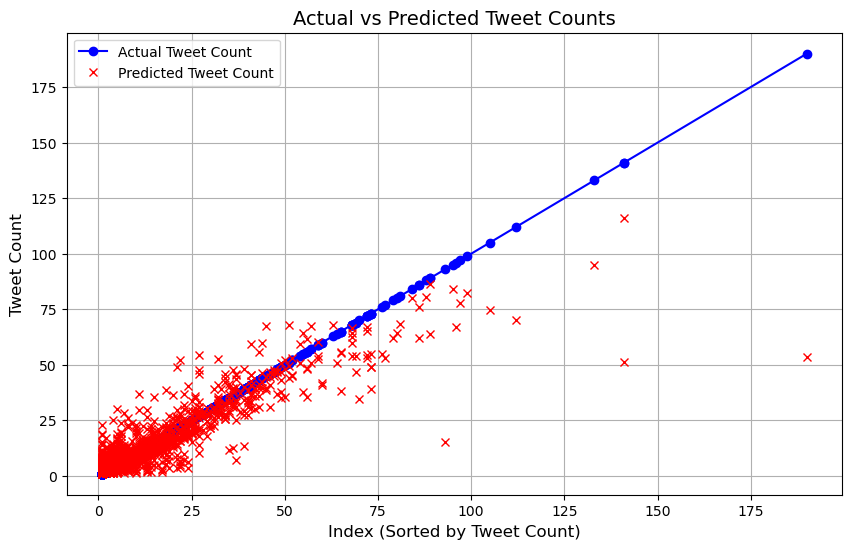

In [127]:
#  Plot the actual and predicted tweet counts
plt.figure(figsize=(10, 6))  # Set the figure size for better readability

# Plot actual tweet counts (blue solid line with circle markers)
plt.plot(df_sorted['tweet_count'], df_sorted['tweet_count'], label='Actual Tweet Count', color='blue', linestyle='-', marker='o')

# Plot predicted tweet counts (red solid line with x markers)
plt.plot(df_sorted['tweet_count'], df_sorted['predicted_tweet_count'], label='Predicted Tweet Count', color='red', linestyle=' ', marker='x')

#  Add labels and a title
plt.xlabel('Index (Sorted by Tweet Count)', fontsize=12)
plt.ylabel('Tweet Count', fontsize=12)
plt.title('Actual vs Predicted Tweet Counts', fontsize=14)

# Legend to differentiate between the two lines
plt.legend()

# Add gridlines for better readability
plt.grid(True)

plt.show()

Nevertheless, we insist that without reliable data on social activities and events, this dataset is more fit for classification than for the  precise predictions of a regression. 

To conlude, by elaborating on the impalanced nature of the dataset which the regression pointed out , it seemed meaningful to show how the distribution of tweets in the province is all but uniform, the division by municipalities correspond to our desire to trace trends in all local municipalities of Trentino, but that is no"efficient approach " to trace overall activity, since, to very good approximation, the actual vast majority of social activities is happening in very, very few places. 

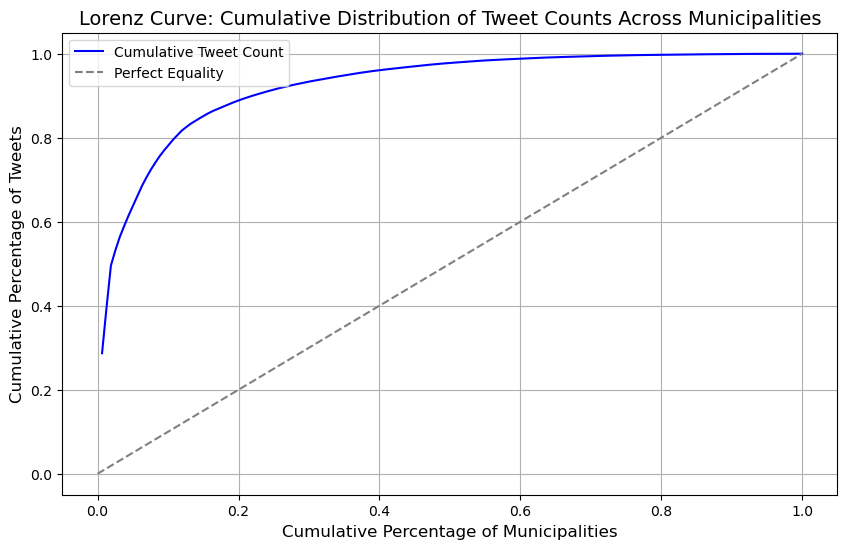

In [142]:
# Step 1: Sort municipalities by tweet count in descending order
df_sorted = df.groupby('municipality.name')['tweet_count'].sum().sort_values(ascending=False)

# Step 2: Calculate cumulative tweet count and cumulative percentage of municipalities
cumulative_tweets = df_sorted.cumsum()
cumulative_percentage_municipalities = np.arange(1, len(df_sorted)+1) / len(df_sorted)

# Step 3: Plot the Lorenz curve
plt.figure(figsize=(10, 6))
plt.plot(cumulative_percentage_municipalities, cumulative_tweets / cumulative_tweets.max(), label="Cumulative Tweet Count", color='blue')

# Step 4: Add a reference line (y = x) for perfect equality
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Equality')

# Step 5: Add labels and title
plt.title('Lorenz Curve: Cumulative Distribution of Tweet Counts Across Municipalities', fontsize=14)
plt.xlabel('Cumulative Percentage of Municipalities', fontsize=12)
plt.ylabel('Cumulative Percentage of Tweets', fontsize=12)

# Step 6: Add a legend and grid
plt.legend()
plt.grid(True)


If the bisector represents perfect equality in the contribution of the municipalities/timeslot classes to tweeting, we see that the distribution is indeed very imbalaced. The two most meaningful insights are that one class accounts for around 30% of the activity and  that 20% of the classes account for more than 90% of the activity. 